<a href="https://colab.research.google.com/github/zmess24/personal-website-nextjs/blob/main/word_2_vec_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After dipping our toes into the waters of Natural Language Processing (NLP) in [my last post](https://www.zacmessinger.com/posts/intro-to-nlp-with-tfidf), we'll be continuing today by exploring one of the most fundamental components of text based deep learning models - word embeddings. Chances are high that you've probably encountered the term "word embeddings" in the buzzing AI community recently. But what are they? Why are they useful? And how do they work?

Today, we're not just going to answer these questions – we're going to get our hands dirty by building a basic version of one of the pioneering word embedding models: Word2Vec.

### What is a Word Embedding?

[In my previous post](https://www.zacmessinger.com/posts/intro-to-nlp-with-tfidf), we broke down one of the oldest NLP methods, TF-IDF vectorization, and explored how it’s an extremely low-cost solution for implementing tasks like relevance ranking based on a set of keywords. However, while TF-IDF can tell us the importance of particular words among a collection of documents, it can’t provide any information about the semantic meaning of those words—such as the meaning or interpretation of a word, phrase, sentence, or text in a specific context. Enter word embeddings!

Word embeddings represent a significant improvement over traditional techniques like TF-IDF by capturing the nuanced relationships between words, rather than just their frequency and importance. Unlike traditional one-hot encoding, which represents words as sparse vectors, word embeddings capture context and semantic relationships between words through dense vectors of floating-point values. This enables more sophisticated and meaningful text analysis, making them incredibly useful in various NLP tasks such as text classification, sentiment analysis, and more. Furthermore, word embeddings are integral components of every large language model (LLM) architecture, serving as the backbone that allows each LLM to translate input text into machine-readable information.

As mentioned, we’ll be implementing Word2Vec, a pioneering neural network-based model introduced by Mikolov et al. in 2013, designed to learn high-quality word embeddings from large text corpora. It operates by predicting words within a local context window, capturing semantic and syntactic relationships between words, and its simplicity and effectiveness have influenced the development of more advanced models, including the aforementioned LLMs.

There are two main approaches within Word2Vec: Skip-gram, which predicts context words given a target word, and Continuous Bag of Words (CBOW), which predicts a target word based on its surrounding context words. Today, we’ll be implementing Skip-gram. Buckle up, here we go!

### Import Libraries

To start, let's go through the routine process of importing a few libraries that we'll use throughout the remainder of this post.

In [31]:
# Core Libraries
import torch

# Data Visualization
import matplotlib.pyplot as plt

# Progress Measurement Library
from tqdm import tqdm

# Web Scraping & TorchInfo
try:
  !pip install beautifulsoup4 torchinfo -q
  from bs4 import BeautifulSoup
  import requests
except:
  from bs4 import BeautifulSoup
  import requests

Additionally, let's enable device agnostic code so we can easily switch our runtimes between using a GPU or CPU depending on what resources are available on our Google Colab environment.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading a Dataset

As with any machine learning project, the first step is to download and prepare a dataset to train our model.

Most modern word embeddings are trained on terabytes of text data from diverse sources, enabling the models to capture a wide range of linguistic patterns and knowledge. However, since we are implementing a simple example, we will work with a much smaller corpus—a single Wikipedia article. An article on Machine Learning seems like an appropriate starting point!

Let’s begin by scraping the text from the Wikipedia article using the requests library, with a little help from BeautifulSoup.



In [3]:
# URL of the ESPN article
url = "https://en.wikipedia.org/wiki/Machine_learning"

# Fetch the HTML content of the page
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Extract the article text
content = soup.find("div", {"id": "mw-content-text"})
paragraphs = content.find_all('p')

# # Combine the paragraphs into a single string
article_text = "\n".join([p.get_text() for p in paragraphs])

To confirm we downloaded everything OK, let's look at the first 1000 characters.

In [4]:
article_text[:1000]

"Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions.[1] Recently, artificial neural networks have been able to surpass many previous approaches in performance.[2][3]\n\nML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine.[4][5] When applied to business problems, it is known under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.\n\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on exploratory data analysis (EDA) through unsupervised learning.[7][8]\n\nFrom a t

Next, we'll need to perform a little data preprocessing in order to prepare our newly acquired corpus for use in the training of our Word2Vec model, and much of the work we'll do here might look familar if you read my last blog post, [Intro to NLP with TF-IDF Vectorization](https://www.zacmessinger.com/posts/intro-to-nlp-with-tfidf). To quickly define what we'll be creating from the raw article text we just downloaded:

* `tokens`: A sanitized list of individual words.
* `vocab`: A sorted set of every unique word in our corpus.
* `word_to_idx`: A lookup table where each unique word in our vocab set is mapped to it's index position.
* `idx_to_word`: A lookup table where the sorted index position of each unique word in our vocab set is mapped to it's associated word.

In [5]:
from collections import Counter
import re

# Tokenize the text
tokens = re.sub(r'[^a-zA-Z\s]', '', article_text).lower().split()

# Build the vocabulary
vocab = sorted(Counter(tokens))
vocab_size = len(vocab)

# Create word to index and index to word mappings
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

print(tokens[:20])

['machine', 'learning', 'ml', 'is', 'a', 'field', 'of', 'study', 'in', 'artificial', 'intelligence', 'concerned', 'with', 'the', 'development', 'and', 'study', 'of', 'statistical', 'algorithms']


### Understanding & Implementing Word2Vec

Before using our newly created dataset to generate training data, let's first walk through the core ideas behind the Word2Vec Skip-gram algorithm to gain a nuanced understanding of its implementation.

Word2Vec leverages the context of words to capture their semantic meanings, with the most critical parameter being the window size. This parameter determines the number of context words considered around a target word, essentially defining the scope of context during training. For example, with a window size of 2, the context for a target word would include the two words preceding it and the two words after it. This local context helps the model learn the relationships and similarities between words based on their surrounding words. The below graphic from [Zafar Ali's Medium article](https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1) does a great job of providing an overview of this crucical concept.

<img src="https://miro.medium.com/v2/resize:fit:536/1*vZhxrBkCz-yN_rzZBqSKiA.png"/>

As you might guess, the choice of window size significantly impacts the quality and nature of the word embeddings.

* A smaller window size tends to capture more syntactic relationships, focusing on immediate neighbors and their roles in sentences. This is beneficial for tasks requiring an understanding of word dependencies and local structures.
* A larger window size encompasses a broader context, capturing more semantic relationships by considering a wider range of surrounding words. This broader context is useful for tasks that require a deeper understanding of the overall meaning in which words appear.

Balancing the window size is crucial: too small a window might miss out on essential context, while too large a window might introduce noise by including less relevant words. Thus, selecting an appropriate window size is key to optimizing Word2Vec for specific applications.

So that will be our goal creating our training data - for every word in our corpus, we will try to generate up to 4 training samples based on a fixed window size of 2. For example, if we take the sentence:

`Recently, artificial neural networks have been able to surpass many previous approaches in performance`

The generated training samples for the word "neural" would be:

* `(neural, Recently)`: 2 words before.
* `(neural, artificial)`: 1 word before.
* `(neural, networks)`: 1 word after.
* `(neural, have)`: 2 words after.

With this understanding in mind, let’s use the algorithm to generate our training data. If done correctly, we should see the above samples represented in the data. One important thing to note: we will use our previously created `word_to_idx` mapping to convert each word into its index position once we’ve defined each pairing, since neural networks require numerical inputs.

In [6]:
def create_training_data(tokens, word_to_idx, window_size=2):
    data = []
    # Loop through each token
    for i in range(window_size, len(tokens) - window_size):
        center_word = tokens[i]
        # Grab previous 'n' words up to the window size
        prevWords = tokens[i - window_size : i]
        # Grab next 'n' words up to the window size
        nextWords = tokens[i + 1 : i + window_size + 1]
        context_words = prevWords + nextWords
        # For each context word, create mapping
        for context_word in context_words:
            data.append((word_to_idx[center_word], word_to_idx[context_word]))

    return data

# Init window size
WINDOW_SIZE = 2

# Create training data
data = create_training_data(tokens, word_to_idx, WINDOW_SIZE)
for pair in data[148:152]: print(idx_to_word[pair[0]], "->", idx_to_word[pair[1]])

neural -> recently
neural -> artificial
neural -> networks
neural -> have


So far so good! We can further valdiate that our `create_training_data` worked correctly by checking the math. Given that we 8,092 tokens in our corpus of text and 32,352 training items, we should expect to see 4 generated training samples for each token. We'll need to subtract 4 from the total number of tokens to account for omitting the first and last two tokens in the corpus, since we cannot generate a full 4 samples in those instances (there's no 2 words preceding the very first token and no 2 words following our very last token).

In [7]:
token_count = len(tokens)
training_sample_count = len(data)
samples_per_token = training_sample_count / (token_count - 4)

print(f"Token Count: {token_count}")
print(f"Training Sample Count: {training_sample_count}")
print(f"Training Samples per Token: {samples_per_token}")

Token Count: 8092
Training Sample Count: 32352
Training Samples per Token: 4.0


The last step is to load our training data into PyTorch's `Dataset` and `DataLoader` modules, which combined provide helpful class utilities for shuffling, batching, and iterating through our data. The `DataLoader` class additionally converts our data into tensors, which is the required data structure for training neural networks.

In [8]:
from torch.utils.data import Dataset, DataLoader

class ArticleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

BATCH_SIZE = 4
dataset = ArticleDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Just to confirm everything is working correctly, let's quickly check the target to context word mappings for a single batch:

In [9]:
center_words, context_words = next(iter(dataloader))

for i in range(BATCH_SIZE):
  center_word, context_word = center_words[i].item(), context_words[i].item()
  print(idx_to_word[center_word], "->", idx_to_word[context_word])

addition -> performance
applications -> for
a -> supervisory
quite -> are


### The Embedding Layer

Now that we’ve created a robust set of training data, it’s time to build our Word2Vec model. The overall architecture we’ll be using is relatively straightforward, as we’ll only need two types of PyTorch layers: nn.Embedding and nn.Linear. Before writing the model, let’s first walk through what each layer does to gain a more comprehensive understanding of the underlying processes. We’ll start with the `nn.Embedding` layer, as it is the first layer our training data will pass through during the forward propagation process.

To begin, we'll initialize an `nn.Embedding` layer with its required inputs: `num_embeddings`, which dictates how many unique embeddings need to be generated (one for each word in our vocabulary), and the embedding_dim, which determines the size of each embedding.

In [11]:
from torch import nn

# CONSTANTS
EMBEDDING_SIZE = 10
VOCAB_SIZE = len(vocab)

# Create embedding layer initialezed with our vocab and target embedding size
embedding_layer = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBEDDING_SIZE)

embedding_layer

Embedding(2072, 10)

Examing the shape of our embedding layer, we can see that we've initialized a tensor with 2072 vectors, each with 10 dimensions. Further, we can see that each of the dimensions for every vector has been ranomly assigned numerical weights, which will be tuned when we start training our model.

In [12]:
for i in range(3):
  vector = embedding_layer.weight[i]
  print(f"Embedding {i}: {vector}")

Embedding 0: tensor([-0.5645,  0.3908, -0.5953,  0.6326, -0.0043,  1.3916, -0.7059,  2.1851,
        -0.2096, -0.1940], grad_fn=<SelectBackward0>)
Embedding 1: tensor([ 0.3147, -0.6228, -2.0910, -0.1696, -0.4416,  0.7745,  1.0487,  0.1452,
         0.9537,  0.5789], grad_fn=<SelectBackward0>)
Embedding 2: tensor([-0.2448,  1.1885,  1.3821,  0.0485, -0.6761, -1.1789, -0.7896,  0.0950,
         1.5438,  1.1849], grad_fn=<SelectBackward0>)


In laymen's terms, what this means is that the embedding layer is essentially a massive lookup table for each unique word in our vocabulary, with each word having an index in the layer and represented by a vector of weights. When we pass in a tensor of word indicies to the embedding layer as an argument, the embedding layer simply returns the corresponding vector for each index. [PyTorch's offical documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) confirms this description:

```
A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.
```

But let's not take PyTorch's word for it. For validation, let's check this out using a single batch from our dataloader, and return the vector for each center word index in our embedding layer.

In [13]:
torch.manual_seed(42)

# Get a single batch of word indexs
sample_center_words, sample_context_words = next(iter(dataloader))

# For each center word, lookup it's index in the embedding layer
for word_index in sample_center_words:
  print(f"Word Index: {word_index.item()}")
  print(f"Vector: {embedding_layer.weight[word_index.item()]}")

Word Index: 1882
Vector: tensor([ 0.8063, -0.0200, -0.6046, -1.7470,  0.7258, -1.9405, -0.6428,  1.5113,
         0.1958, -0.9417], grad_fn=<SelectBackward0>)
Word Index: 392
Vector: tensor([-1.2796,  0.0407, -1.3964, -1.4239, -0.8699, -1.6921,  0.6305, -0.9170,
        -1.3376, -0.9535], grad_fn=<SelectBackward0>)
Word Index: 446
Vector: tensor([ 1.0075,  1.3089, -1.4465,  0.2294,  1.1204,  0.5663,  1.9597, -0.3894,
        -0.3001,  0.1824], grad_fn=<SelectBackward0>)
Word Index: 2002
Vector: tensor([-0.6333, -0.2762,  1.1233, -0.5011, -0.1019, -2.3611,  0.3806, -1.6786,
        -1.5883,  1.2122], grad_fn=<SelectBackward0>)


And now, let's cross reference those results with what get's returned when we just pass in the tensor directly to the embedding layer:

In [14]:
embeddings = embedding_layer(sample_center_words)
embeddings

tensor([[ 0.8063, -0.0200, -0.6046, -1.7470,  0.7258, -1.9405, -0.6428,  1.5113,
          0.1958, -0.9417],
        [-1.2796,  0.0407, -1.3964, -1.4239, -0.8699, -1.6921,  0.6305, -0.9170,
         -1.3376, -0.9535],
        [ 1.0075,  1.3089, -1.4465,  0.2294,  1.1204,  0.5663,  1.9597, -0.3894,
         -0.3001,  0.1824],
        [-0.6333, -0.2762,  1.1233, -0.5011, -0.1019, -2.3611,  0.3806, -1.6786,
         -1.5883,  1.2122]], grad_fn=<EmbeddingBackward0>)

Not too shabby! We're halfway there - let's move onto `nn.Linear` layer next.

### The Linear Layer

The linear layer is where the magic really starts to happen within the Word2Vec model. It applies a linear transformation to our embeddings to produce logits (scores) indicating the model’s confidence or likelihood of each word being a context word given the target (center) word. In practice, we would then return the word with the highest probability score as the one with the most similar context to the provided target word.

We can instantiate an `nn.Linear` layer by passing in two arguments: the size of the input features, which in this case is equal to the size of the embeddings produced by our embedding layer, and the size of the output features, which corresponds to the number of unique words in our vocabulary.

Similar to our embedding layer, the linear layer should generate a tensor with 2072 vectors, each with 10 randomly assigned weights.

In [16]:
linear_layer = nn.Linear(in_features=EMBEDDING_SIZE, out_features=VOCAB_SIZE)

linear_layer.weight.shape

torch.Size([2072, 10])

I’ve covered the math behind linear transformations on tensors in previous posts, but I’ll provide a brief overview here. Recall that the equation for a linear transformation is defined as follows:


$y = W(x) + b$

Where, in the context of Word2Vec:

- $x$ is the input embedding vector (with a size equal to the embedding dimension).
- $W$ is the weight matrix (with dimensions  $\text{vocabulary size} \times \text{embedding dimension}$ ).
- $b$ is the bias vector (with a length equal to the vocabulary size).
- $y$ is the output vector e.g logits (with a length equal to the vocabulary size).

Essentially, this equation boils down to performing a dot product multiplication between the weights of the linear layer and each embedding in the batch returned from the embedding layer, followed by adding a bias vector to the results.

Let’s verify the math programmatically below by checking the shapes of the tensors as we progress through the transformations:


In [17]:
# Define X, b, and w
x = embeddings
W = linear_layer.weight.t()
b = linear_layer.bias

# Perform Linear Transformation
Wx = torch.matmul(x, W)
y = Wx + b

# Print Shapes
print(f"Wx = W: ({W.shape}) * x({x.shape})")
print(f"y = Wx: {Wx.shape} + b{b.shape}")
print(f"y = {y.shape}")

Wx = W: (torch.Size([10, 2072])) * x(torch.Size([4, 10]))
y = Wx: torch.Size([4, 2072]) + btorch.Size([2072])
y = torch.Size([4, 2072])


Perfect, this checks out! Now, let’s examine the first 10 logits of each output tensor and compare them to the results of passing the embeddings directly through the linear_layer function we defined earlier.

In [18]:
logits = linear_layer(embeddings)

print(y[0][:10])
print(logits[0][:10])

tensor([ 0.3426, -0.6318,  0.4095, -0.8184,  0.5423,  0.8332, -0.0304,  0.4351,
         0.1798,  0.0202], grad_fn=<SliceBackward0>)
tensor([ 0.3426, -0.6318,  0.4095, -0.8184,  0.5423,  0.8332, -0.0304,  0.4351,
         0.1798,  0.0202], grad_fn=<SliceBackward0>)


Nice, we got a one to one match! As a final step, let's convert the logits into probability scores using a softmax function to predict the top 3 context words for each target word, and see what gets returned just for fun:

In [21]:
import torch.nn.functional as F

# How many context words to return for the given target word
k = 3

# Apply softmax to get probabilities
probabilities = F.softmax(logits, dim=1)

for i in range(len(probabilities)):
  top_k_probs, top_k_indices = torch.topk(probabilities[i], k)
  # Convert indices to words, filtering out the input word
  predicted_words = []

  for idx in top_k_indices:
      predicted_word = idx_to_word[idx.item()]
      predicted_words.append(predicted_word)

  print(f"Target Word '{idx_to_word[context_words[i].item()]}', Top 3 Predicted Next Words: {predicted_words} ")

Target Word 'performance', Top 3 Predicted Next Words: ['unzip', 'substantial', 'possible'] 
Target Word 'for', Top 3 Predicted Next Words: ['synapses', 'animal', 'inference'] 
Target Word 'supervisory', Top 3 Predicted Next Words: ['digitizing', 'emotion', 'killed'] 
Target Word 'are', Top 3 Predicted Next Words: ['basis', 'lzw', 'offers'] 


Well, I guess some of these might make sense? But for the most part they seem pretty random, which is what we should expect given we haven't performed any training yet. Nonetheless, this is still pretty cool in my opinion, and provides a vision of the value our Word2Vec model could provide once it's better learned and instilled the semantic meanings of each word into it's embedding vectors.

### Defining a Word2Vec Model and Setting up a Training Function

With that, it's time to finally put everything we've learned so far together! Let's begin by defining our Word2Vec model. As mentioned before, the architecture is relatively straightforward and only consists of the `nn.Embedding` and `nn.Linear` layers that we just covered.

In [23]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        return self.linear(self.embeddings(inputs))

VOCAB_SIZE = len(vocab)
EMBEDDING_SIZE = 10

model = Word2Vec(vocab_size=VOCAB_SIZE, embedding_size=EMBEDDING_SIZE)

As a quick aside, in the forward method (which is a mandatory `nn.Module` class method), I've decided to directly invoke the layers in a single line, which offers slight computational speedups due to reducing the number of lines of code. However, this comes at the drawback of leaving the code harder to debug, less flexible to changes, and less readible overall.

For smaller, more simple models like Word2Vec, this implementation works fine, but with larger models it is more likely to see the outputs of each layer seperated out for modularity. For instance, we could re-write our `forward` method like so if we wanted to change to the multi-line approach:

In [24]:
def forward(self, inputs):
    embeddings = self.embeddings(inputs)
    logits = self.linear(embeddings)
    return logits

Next, we need to define our training function, which is reponsible for adjusting the weights of our model over time. The training of the Word2Vec model is no different than most neural networks, following the below five core steps:

1. **Forward Pass**: We pass our batch of target word index tensors through our model to produce a tensor of probability logits for potential context words.
2. **Calculate the Loss**: We evaluate the performance of our model by measuring the loss of our model's outputs against our labels (e.g actual context words) using the cross-entropy loss function.
3. **Backpropogation**: We then calculate the gradient of the loss with respect to every model parameter to be updated in reverse layer order, starting with the linear layer. This step is crucial for understanding how changes in each parameter affect the overall loss.
4. **Update the Optimizer**: The model updates parameters that have requires_grad=True based on the loss gradients to optimize them via gradient descent. We didn’t explicitly set requires_grad=True for any of our layers because this is PyTorch’s default behavior for layer parameters
5. **Zero the Gradients**: We reset the current optimizer's gradients to zero (they are accumulated by default) so they can be recalculated in the next training step.

Additionally, we’ll add code to track the total loss over time, allowing us to measure our model’s learning progress. As a reminder, the loss represents the numerical difference between the model’s outputs and the actual targets for each training epoch. The closer the loss is to zero, the better the model has learned the patterns in the training data, leading to more accurate predictions.

In [32]:
def train(model, data, epochs, loss_fn, optimizer, batch_size):
    loss_history = []
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for target_word, context_word in dataloader:
          # 1. Forward Pass
          logits = model(target_word)
          # 2. Calculate the Loss
          loss = loss_fn(logits, context_word)
          total_loss += loss.item()
          # 3. Backpropogation
          loss.backward()
          # 4. Perform Gradient Descent to update the weights
          optimizer.step()
          # 5. Zero out gradients
          optimizer.zero_grad()

        # Append total loss to loss history
        loss_history.append(total_loss)

    return model, loss_history

### Putting it all together

We’ve arrived at the moment of truth! Let’s combine all the individual components from this post into a single code block and train our Word2Vec model.

A couple of quick notes before running this code:

* We’ll start with a BATCH_SIZE of 256 to speed up the training of our model and give it more capacity to learn from the data.
* Although we are using Adam as our optimizer, Word2Vec was [originally trained by Google](https://arxiv.org/pdf/1301.3781) using a variation of Mini-Batch Stochastic Gradient Descent (SGD) called Adagrad. Adam incorporates the core principles of Adagrad with some additional improvements.
* For now, we are using static hyperparameters, but we could test different combinations via grid search to determine which configurations yield the best model results.



In [33]:
# Contants
LEARNING_RATE = 0.01
EPOCHS = 100
WINDOW_SIZE = 2
EMBEDDING_SIZE = 10
BATCH_SIZE = 256

# Tokenize the text
tokens = re.sub(r'[^a-zA-Z\s]', '', article_text).lower().split()

# Build the vocabulary
vocab = sorted(Counter(tokens))
vocab_size = len(vocab)

# Create word to index and index to word mappings
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# Convert book into dataset
dataset = ArticleDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the training data
data = create_training_data(tokens, word_to_idx, WINDOW_SIZE)

# Init Model
model = Word2Vec(vocab_size=vocab_size, embedding_size=EMBEDDING_SIZE)

# Set Loss Function and Optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
model, loss_history = train(model=model,
                       data=dataloader,
                       epochs=EPOCHS,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       batch_size=BATCH_SIZE)

100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


We can analyze how well Word2Vec learned our dataset by looking at the loss history over time.

<ipython-input-35-4d711f2c0590>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


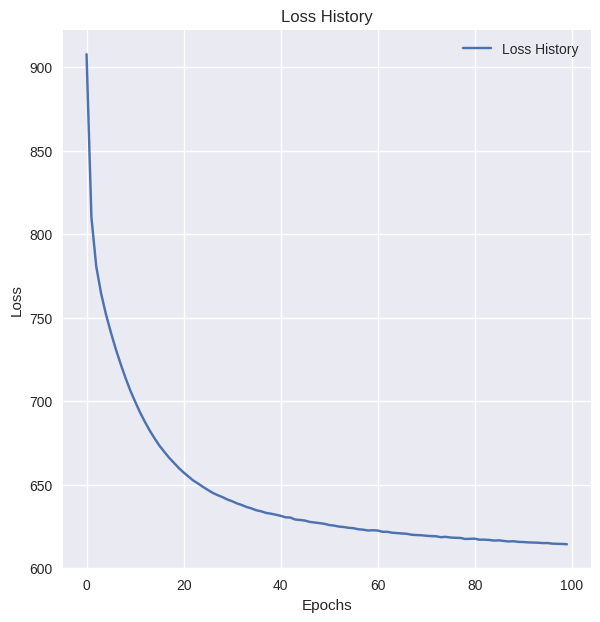

In [35]:
# Figure out how many epochs there were
epochs = range(len(loss_history))

# Setup a plot
plt.figure(figsize=(15, 7))
plt.style.use("seaborn")

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, label='Loss History')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Our loss history suggests that our model was able to successfully learn and generalize from our text corpus, as we can observe a sharp decrease in total loss with each successive epoch up until about the 40th epoch. It's possible that we could have further reduced the loss by playing around with some of our hyperparameters, but for now, this initial training instance seems promoising.

However, a better gauge of whether we were successful in our pursuit might be to actually plug in a few target word and see what context words get returned. Let's try it out by inputting the word "neural" into our Word2Vec model.

In [38]:
import torch.nn.functional as F

def predict_next_word(model, word, word_to_idx, idx_to_word, top_k=5):
  model.eval()
  # Convert the word to its corresponding index
  word_idx = torch.tensor([word_to_idx[word]], dtype=torch.long)

  # Forward pass through the model
  with torch.no_grad():
      output = model(word_idx)

  # Apply softmax to get probabilities
  probabilities = F.softmax(output, dim=1)

  # Get the top k predictions
  top_k_probs, top_k_indices = torch.topk(probabilities, top_k + 1)  # Get top k + 1 to ensure we can omit the input word

  # Convert indices to words, filtering out the input word
  context_words = []
  for idx in top_k_indices[0]:
      predicted_word = idx_to_word[idx.item()]
      if predicted_word != word:
          context_words.append(predicted_word)
      if len(context_words) == top_k:
          break

  return context_words

# Predict the next word for a given input word
input_word = 'neural'
predicted_words = predict_next_word(model, input_word, word_to_idx, idx_to_word, top_k=3)
print(f"Words most similar to '{input_word}': {predicted_words}")

Words most similar to 'neural': ['a', 'networks', 'artificial']


This is pretty good! The words "networks" and "artificial" definitely seem like they would be heavily associated with "neural". I would say this passes the eye test, and validates what the loss curve inferred to us.

### Conclusion

While this was a relatively simple implementation of the Word2Vec model, I hope you gained a better appreciation for the value of word embeddings—I know I certainly did. Although Word2Vec may be somewhat outdated compared to state-of-the-art architectures like transformers, the core principles remain relevant. The idea that we can capture the semantic meaning of a word by leveraging the surrounding words for context, and then embed those relationships into a vector space, is fundamental to many modern NLP techniques. Impressively, the underlying math is not overly complex—as we saw, these mappings can be generated using basic linear algebra and calculus. In my opinion, this simplicity makes the architecture even more remarkable.

Thanks for taking the time to read this, and hopefully you were able to learn something new. I'll see you next time.